In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [3]:
train_df = train_df.fillna("")
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404290 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


In [4]:
test_df = test_df.fillna("")
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2345796 entries, 0 to 2345795
Data columns (total 3 columns):
test_id      int64
question1    object
question2    object
dtypes: int64(1), object(2)
memory usage: 53.7+ MB


In [5]:
train_df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


In [7]:
question1_train = train_df['question1'].values.tolist()
question2_train = train_df['question2'].values.tolist()
question1_test = test_df['question1'].values.tolist()
question2_test = test_df['question2'].values.tolist()

In [8]:
print(len(question1_train))
print(len(question2_train))
print(len(question1_test))
print(len(question2_test))

404290
404290
2345796
2345796


In [9]:
questions_train = question1_train + question2_train
len(questions_train)

808580

In [10]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer()
tokenizer.fit_on_texts(questions_train)

# num of tokens (unique word)
len(tokenizer.word_index)

Using TensorFlow backend.


95596

In [11]:
# min, max, avg word sequences length
quest_len_list = [len(quest.split()) for quest in questions_train]
print(min(quest_len_list))
print(max(quest_len_list))
print(sum(quest_len_list) // len(quest_len_list))

0
237
11


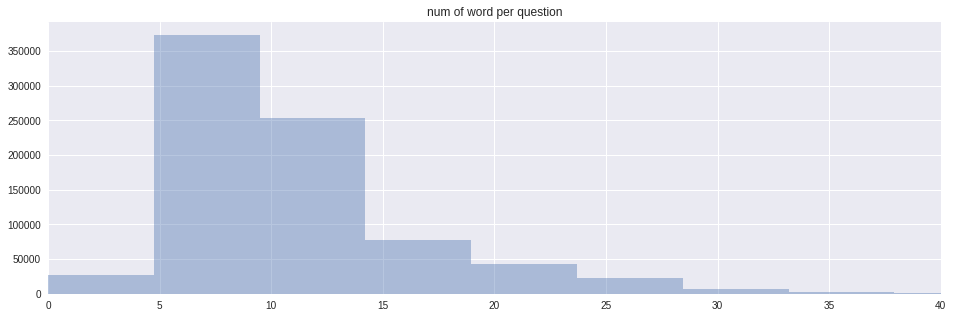

In [12]:
fig = plt.figure(figsize=(16,5))
plt.xlim(0,40)
sns.distplot(quest_len_list, kde=False)
plt.title('num of word per question')
plt.show()

In [13]:
MAX_NUM_WORDS = 90000
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 30

In [14]:
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(question1_train + question2_train)

In [15]:
seq_train_1 = tokenizer.texts_to_sequences(question1_train)
seq_train_2 = tokenizer.texts_to_sequences(question2_train)
seq_test_1 = tokenizer.texts_to_sequences(question1_test)
seq_test_2 = tokenizer.texts_to_sequences(question2_test)

In [16]:
train_1 = pad_sequences(seq_train_1, maxlen=MAX_SEQUENCE_LENGTH)
train_2 = pad_sequences(seq_train_2, maxlen=MAX_SEQUENCE_LENGTH)
test_1 = pad_sequences(seq_test_1, maxlen=MAX_SEQUENCE_LENGTH)
test_2 = pad_sequences(seq_test_2, maxlen=MAX_SEQUENCE_LENGTH)

In [17]:
print(train_1.shape)
print(train_2.shape)
print(test_1.shape)
print(test_2.shape)

(404290, 30)
(404290, 30)
(2345796, 30)
(2345796, 30)


In [18]:
y_train = train_df['is_duplicate'].values

In [19]:
import os.path
EMBEDDING_DIR = 'glove/'
embedding_index = {}
with open(os.path.join(EMBEDDING_DIR, 'glove.6B.300d.txt')) as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
    
print('found %d word vectors' % len(embedding_index))

found 400000 word vectors


In [20]:
embedding_matrix = np.zeros((MAX_NUM_WORDS, EMBEDDING_DIM))
for word, i in tokenizer.word_index.items():
    if i >= MAX_NUM_WORDS:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [21]:
from keras.models import Model
from keras.layers import Input, Dense, Dropout
from keras.layers import Embedding, Conv1D, MaxPooling1D, LSTM
from keras.layers import concatenate
from keras.layers.normalization import BatchNormalization

embedding_layer = Embedding(input_dim=MAX_NUM_WORDS, output_dim=EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                           weights=[embedding_matrix], trainable=False)

sequence_1_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
embedded_sequence_1 = embedding_layer(sequence_1_input)
x1 = Conv1D(128, 5, activation='relu')(embedded_sequence_1)
x1 = MaxPooling1D(pool_size=2)(x1)
x1 = Dropout(0.3)(x1)
x1 = BatchNormalization()(x1)
x1 = LSTM(64)(x1)
x1 = Dropout(0.3)(x1)
x1 = BatchNormalization()(x1)
x1 = Dense(64, activation='relu')(x1)

sequence_2_input = Input(shape=(MAX_SEQUENCE_LENGTH, ))
embedded_sequence_2 = embedding_layer(sequence_2_input)
x2 = Conv1D(128, 5, activation='relu')(embedded_sequence_2)
x2 = MaxPooling1D(pool_size=2)(x2)
x2 = Dropout(0.3)(x2)
x2 = BatchNormalization()(x2)
x2 = LSTM(64)(x2)
x2 = Dropout(0.3)(x2)
x2 = BatchNormalization()(x2)
x2 = Dense(64, activation='relu')(x2)

merged = concatenate([x1, x2])
y = Dropout(0.3)(merged)
y = BatchNormalization()(y)
y = Dense(32, activation='relu')(y)
y = Dropout(0.3)(y)
y = BatchNormalization()(y)
y = Dense(1, activation='sigmoid')(y)

model = Model(inputs=[sequence_1_input, sequence_2_input], outputs=y)
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [22]:
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
input_2 (InputLayer)             (None, 30)            0                                            
____________________________________________________________________________________________________
embedding_1 (Embedding)          (None, 30, 300)       27000000                                     
____________________________________________________________________________________________________
conv1d_1 (Conv1D)                (None, 26, 128)       192128                                       
___________________________________________________________________________________________

In [23]:
model.fit([train_1, train_2], y_train, epochs=20, batch_size=1024, verbose=2)

Epoch 1/20
87s - loss: 0.6005 - acc: 0.6824
Epoch 2/20
42s - loss: 0.5199 - acc: 0.7421
Epoch 3/20
42s - loss: 0.4944 - acc: 0.7593
Epoch 4/20
42s - loss: 0.4750 - acc: 0.7712
Epoch 5/20
42s - loss: 0.4588 - acc: 0.7819
Epoch 6/20
42s - loss: 0.4457 - acc: 0.7893
Epoch 7/20
42s - loss: 0.4337 - acc: 0.7971
Epoch 8/20
42s - loss: 0.4209 - acc: 0.8046
Epoch 9/20
42s - loss: 0.4102 - acc: 0.8112
Epoch 10/20
42s - loss: 0.3996 - acc: 0.8175
Epoch 11/20
42s - loss: 0.3912 - acc: 0.8217
Epoch 12/20
42s - loss: 0.3815 - acc: 0.8278
Epoch 13/20
42s - loss: 0.3733 - acc: 0.8325
Epoch 14/20
42s - loss: 0.3656 - acc: 0.8364
Epoch 15/20
42s - loss: 0.3569 - acc: 0.8414
Epoch 16/20
42s - loss: 0.3507 - acc: 0.8440
Epoch 17/20
42s - loss: 0.3434 - acc: 0.8481
Epoch 18/20
42s - loss: 0.3378 - acc: 0.8507
Epoch 19/20
42s - loss: 0.3306 - acc: 0.8552
Epoch 20/20
42s - loss: 0.3252 - acc: 0.8577


In [24]:
y_pred = model.predict([test_1, test_2], batch_size=4096, verbose=1)
print(y_pred.shape)
print(y_pred[:3])

2345796/2345796 [==============================] - 61s      

In [25]:
submissions = pd.DataFrame({'test_id': test_df['test_id'], 'is_duplicate': y_pred.ravel()})
submissions.head()

,is_duplicate,test_id
0,0.118128,0
1,0.073540,1
2,0.710063,2
3,0.092558,3
4,0.576819,4


In [26]:
submissions.to_csv('submissions.csv', index=False)